# Board Game Recommender

In [1]:
# Import necessary packages
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import time
import matplotlib.pyplot as plt 
from IPython.display import display, clear_output

%matplotlib inline

In [2]:
def politerequest(url, delay=1):
    """This function tries to get a webpage.
    If the request returns a status code 429 Too Many Requests, the program waits before the next attempt"""
    
    # make a request to the url and then wait
    r = requests.get(url)
    time.sleep(delay)
    
    # wait longer if server returns status 429 for too many requests or 5xx for server error
    n = 0
    while (r.status_code == 429) | (r.status_code >= 500):
        waittime = 2**n
        n+=1
        display('Too many attempts. Waiting ' + str(waittime) + ' seconds.')
        clear_output(wait=True)
        time.sleep(waittime)
        r = requests.get(game_url)
    return r

In [10]:
# base url to find board game rankings and IDs
base_url = 'https://boardgamegeek.com/browse/boardgame/page/'
game_dict = {}

# page to start on
page = 1

# set number of games to scrape info on, games will be chosen and ordered by popularity
gamecount = 7000

while len(game_dict) < gamecount:
    
    # make request and display current page on BGG; site loads 100 games per page
    r = politerequest(base_url + str(page),0.25)
    
    # iterate page
    page += 1
    
    # load page html and parse out game name, rank, ID number, and number of voter
    soup = BeautifulSoup(r.content, 'lxml')
    games = soup.find_all('div', id = re.compile('results_objectname.+?'))
    ranks = soup.find_all('td', class_ = 'collection_rank')
    nums_votersoup = soup.find_all('td', class_ = 'collection_bggrating')[2::3]
    
    # create dictionary from scraped information
    for rank, game, num_votersoup in zip(ranks, games, nums_votersoup):
        num_voters = int(num_votersoup.text)
        try:
            rank_num = rank.a.get('name')
        except:
            rank_num = None
        if (rank_num is not None) & (num_voters >= 100):
            game_id = re.search('boardgame/(.+?)/', str(game)).group(1)
            game_name = game.a.get_text()
            game_rank = rank_num
            game_dict[game_id] = {'name': game_name, 'rank': game_rank, 'num_voters': num_voters}
    
    # update display progress
    clear_output(wait=True)
    display('Done gathering '+str(len(game_dict))+' of '+str(gamecount)+' game IDs, names, and rankings.')

# update display when finished
clear_output(wait=True)
display('Done gathering '+str(len(game_dict))+' game IDs, names, and rankings.')

'Done gathering 7012 game IDs, names, and rankings.'

In [11]:
def chunks(l, n):
    '''Iterator function to group together game IDs to reduce API requests'''
    # for item i in a range that is a length of l,
    for i in range(0, len(l), n):
        # create an index range for l of n items:
        yield l[i:i+n]

# number of game IDs to group
chunksize = 25

# sort IDs by number of votes to minimize number of requests to API
rank_df = pd.DataFrame.from_dict(game_dict, orient = 'index')
rank_df = rank_df.sort_values('num_voters', ascending = False)

# call chunks to group IDs
id_blocks = list(chunks(list(rank_df.index), chunksize))

# join lists of IDs into strings for API requests
id_block_str = []
for id_block in id_blocks:
    id_block_str.append(','.join(id_block))

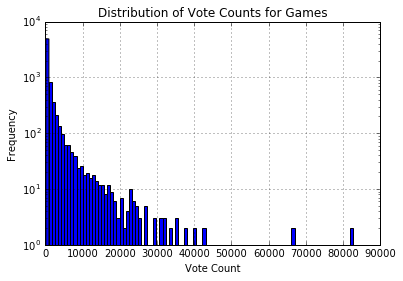

Gathering data for these 7012 games will take about 5276 requests


In [12]:
# plot histogram of game vote counts
rank_df.hist('num_voters',bins=100,log=True)
plt.xlabel('Vote Count')
plt.ylabel('Frequency')
plt.title('Distribution of Vote Counts for Games')
plt.show()

# calculate how many API requests to get an idea of time
vote_counts = list(rank_df.num_voters)[::chunksize]
totalpages = 0
for vote_count in vote_counts:
    totalpages += vote_count//100+1
print 'Gathering data for these '+str(len(game_dict))+' games will take about '+str(totalpages)+' requests'

In [21]:
for index, id_block in enumerate(id_block_str,1):
    # load first page and parse out actual number of comments to determine how many pages of information to request for this block of games
    # 100 comments per page
    game_url = 'https://boardgamegeek.com/xmlapi2/thing?id='+id_block+'&stats=1&ratingcomments=1&page=1'
    r = politerequest(game_url, 1)
    soup = BeautifulSoup(r.content, 'lxml-xml')
    itemssoup = soup.findAll('item')
    ncommentpages = int(soup.find('comments')['totalitems'])//100+1
    
    for page in range(1,ncommentpages+1):
        # display progress
        clear_output(wait=True)
        display(str('Parsing page '+str(page)+' of '+str(ncommentpages)+' in block '+str(index)+' of '+str(len(id_block_str))))
        
        if page == 1:
            # gather and store important game information on the first page
            for itemsoup in itemssoup:
                id = itemsoup['id']

                attributes = {}
                attributesoup = itemsoup.findAll('link')
                for attribute in attributesoup:
                    attributes[attribute['type']] = attribute['value']

                ratings = {}
                commentsoup = itemsoup.findAll('comment')
                for comment in commentsoup:
                    ratings[comment['username']] = comment['rating']

                player_count = {}
                countsoup = itemsoup.findAll('results', numplayers = re.compile(''))
                for count in countsoup:
                    resultsoup = count.findAll('result')
                    vote_count = {}
                    for result in resultsoup:
                        vote_count[result['value']] = result['numvotes']
                    player_count[count['numplayers']] = vote_count
                
                average_rating = itemsoup.average['value']
                weighted_rating = itemsoup.bayesaverage['value']
                play_time = itemsoup.playingtime['value']
                weight = itemsoup.averageweight['value']
                description = itemsoup.description.text
                year = itemsoup.yearpublished['value']
                
                game_dict[id].update({'average_rating':average_rating, 'weighted_rating':weighted_rating, 'description':description,
                                    'attributes': attributes, 'player_count': player_count, 'play_time':play_time, 'year':year,
                                    'weight':weight, 'ratings':ratings})

        else:
            # if there is more than 1 page, load them 1 at a time
            game_url = 'https://boardgamegeek.com/xmlapi2/thing?id='+id_block+'&stats=1&ratingcomments=1&page='+str(page)
            r = politerequest(game_url, 1)
            soup = BeautifulSoup(r.content, 'lxml-xml')
            itemssoup = soup.findAll('item')
            
            # gather and store game ratings from current page
            for itemsoup in itemssoup:
                id = itemsoup['id']
                commentsoup = itemsoup.findAll('comment')
                for comment in commentsoup:
                    game_dict[id]['ratings'][comment['username']] = comment['rating']
                    
        current_time = str(time.ctime())
        for itemsoup in itemssoup:
                id = itemsoup['id']
                game_dict[id]['last_updated'] = current_time
        
clear_output(wait=True)
display('Done')

'Done'

In [22]:
game_df = pd.DataFrame.from_dict(game_dict, orient = 'index')
game_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7012 entries, 1 to 99975
Data columns (total 13 columns):
ratings            7012 non-null object
last_updated       7012 non-null object
player_count       7012 non-null object
num_voters         7012 non-null int64
name               7012 non-null object
weight             7012 non-null object
rank               7012 non-null object
average_rating     7012 non-null object
year               7012 non-null object
attributes         7012 non-null object
play_time          7012 non-null object
weighted_rating    7012 non-null object
description        7012 non-null object
dtypes: int64(1), object(12)
memory usage: 766.9+ KB


In [24]:
game_df.to_json('bgg_database.json')
game_df.head()

,ratings,last_updated,player_count,num_voters,name,weight,rank,average_rating,year,attributes,play_time,weighted_rating,description
1,"{u'aSoso': u'10', u'Annagul': u'7', u'the_ka':...",Tue Jan 29 22:56:21 2019,"{u'1': {u'Recommended': u'1', u'Not Recommende...",4752,Die Macher,4.3434,208,7.64052,1986,"{u'boardgamedesigner': u'Karl-Heinz Schmiel', ...",240,7.20468,Die Macher is a game about seven sequential po...
10,"{u'Igorken': u'6', u'druvey': u'4', u'Joverowa...",Tue Jan 29 22:25:44 2019,"{u'6+': {u'Recommended': u'1', u'Not Recommend...",7302,Elfenland,2.162,850,6.73401,1998,"{u'boardgamedesigner': u'Alan R. Moon', u'boar...",60,6.54036,Elfenland is a redesign of the original White ...
100169,"{u'dougadamsau': u'8', u'cayluster': u'8.5', u...",Wed Jan 30 00:49:00 2019,"{u'1': {u'Recommended': u'1', u'Not Recommende...",146,Hero of Weehawken,2.1579,3965,7.57304,2011,"{u'boardgamedesigner': u'Robert Leonhard', u'b...",45,5.72521,Historic Gaming #7&#10;&#10;Hero of Weehawken ...
100172,"{u'skelebone': u'8', u'infinity13': u'7.5', u'...",Wed Jan 30 00:49:06 2019,"{u'6+': {u'Recommended': u'0', u'Not Recommend...",144,Seven Sisters,2.4118,5653,6.81274,2012,"{u'boardgamedesigner': u'Brad Champeny', u'boa...",60,5.62356,The King's birthday has arrived! Wealthy arist...
1002,"{u'dakarp': u'8', u'hurrlipurr': u'7', u'sanny...",Wed Jan 30 00:33:14 2019,"{u'1': {u'Recommended': u'0', u'Not Recommende...",442,Cosmic Eidex,2.6909,2783,6.90081,1998,"{u'boardgamedesigner': u'Urs Hostettler', u'bo...",60,5.87718,Cosmic Eidex is an intriguing little trick-tak...
